# Differentiators in PySINDy

This notebook explores the differentiation methods available in PySINDy. Most of the methods are powered by the [derivative](https://pypi.org/project/derivative/) package. While this notebook explores these methods on temporal data, these apply equally well to the computation of spatial derivatives for SINDy for PDE identification (see example Jupyter notebooks on PDEs and weak forms).

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.4.3?filepath=examples/5_differentation.ipynb)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
import seaborn as sns
from pysindy.utils import linear_damped_SHO, lorenz

import pysindy as ps

# ignore user warnings
import warnings
warnings.filterwarnings("ignore")

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-15
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-15

In the cell below we define all the available differentiators. Note that the different options in `SINDyDerivative` all originate from `derivative`.

* `FiniteDifference` - First order (forward difference) or second order (centered difference) finite difference methods with the ability to drop endpoints. Does *not* assume a uniform time step. Appropriate for smooth data.
* `finite_difference` - Central finite differences of any order. Assumes a uniform time step. Appropriate for smooth data.
* `Smoothed Finite Difference` - `FiniteDifference` with a smoother (default is Savitzky Golay) applied to the data before differentiation. Appropriate for noisy data.
* `savitzky_golay` - Perform a least-squares fit of a polynomial to the data, then compute the derivative of the polynomial. Appropriate for noisy data.
* `spline` - Fit the data with a spline (of arbitrary order) then perform differentiation on the spline. Appropriate for noisy data.
* `trend_filtered` - Use total squared variations to fit the data (computes a global derivative that is a piecewise combination of polynomials of a chosen order). Set `order=0` to obtain the total-variational derivative. Appropriate for noisy data
* `spectral` - Compute the spectral derivative of the data via Fourier Transform. Appropriate for very smooth (i.e. analytic) data.

In [2]:
diffs = [
    ('PySINDy Finite Difference', ps.FiniteDifference()),
    ('Finite Difference', ps.SINDyDerivative(kind='finite_difference', k=1)),
    ('Smoothed Finite Difference', ps.SmoothedFiniteDifference()),
    ('Savitzky Golay', ps.SINDyDerivative(kind='savitzky_golay', left=0.5, right=0.5, order=3)),
    ('Spline', ps.SINDyDerivative(kind='spline', s=1e-2)),
    ('Trend Filtered', ps.SINDyDerivative(kind='trend_filtered', order=0, alpha=1e-2)),
    ('Spectral', ps.SINDyDerivative(kind='spectral')),
]

plot_kws = dict(alpha=0.7, linewidth=3)
pal = sns.color_palette("Set1")

## Compare differentiation methods directly
First we'll use the methods to numerically approximate derivatives to measurement data directly, without bringing SINDy into the picture. We'll compare the different methods' accuracies when working with clean data ("approx" in the plots) and data with a small amount of white noise ("noisy").

In [3]:
noise_level = 0.01

In [4]:
def compare_methods(diffs, x, y, y_noisy, y_dot):
    n_methods = len(diffs)
    n_rows = (n_methods // 3) + int(n_methods % 3 > 0)
    fig, axs = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows), sharex=True)

    for (name, method), ax in zip(diffs, axs.flatten()):
        ax.plot(x, y_dot, label='Exact', color=pal[0], **plot_kws)
        ax.plot(x, method(y, x), ':', label='Approx.', color='black', **plot_kws)
        ax.plot(x, method(y_noisy, x), label='Noisy', color=pal[1], **plot_kws)
        ax.set(title=name)

    axs[0, 0].legend()
    fig.show()
    
    return axs

### Sine

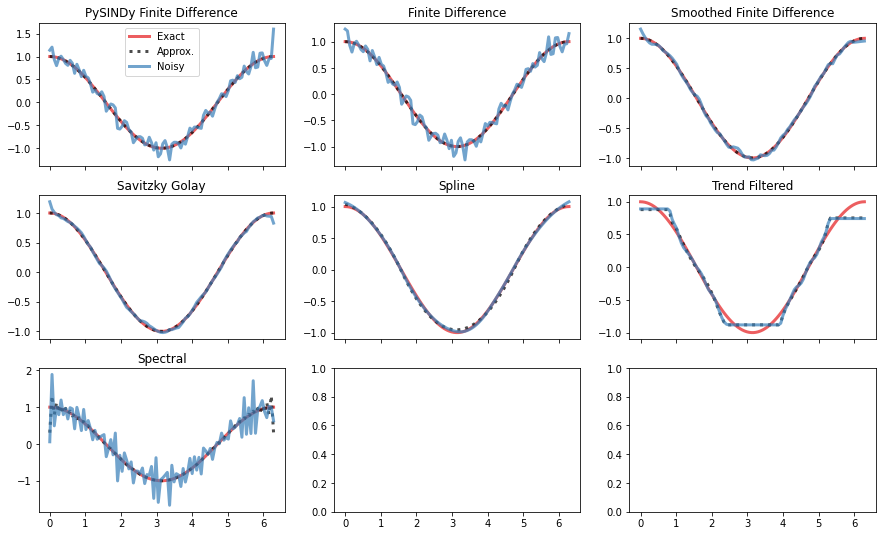

In [5]:
# True data
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)
y_dot = np.cos(x)

# Add noise
seed = 111
np.random.seed(seed)
y_noisy = y + noise_level * np.random.randn(len(y))

axs = compare_methods(diffs, x, y, y_noisy, y_dot)

### Absolute value

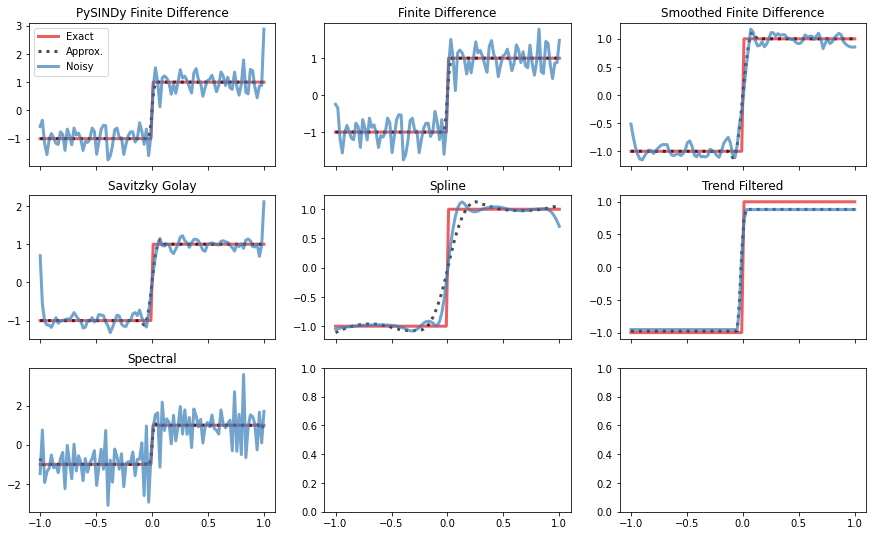

In [6]:
# Shrink window for Savitzky Golay method
diffs[3] = ('Savitzky Golay', ps.SINDyDerivative(kind='savitzky_golay', left=0.1, right=0.1, order=3))

# True data
x = np.linspace(-1, 1, 100)
y = np.abs(x)
y_dot = np.sign(x)

# Add noise
seed = 111
np.random.seed(seed)
y_noisy = y + noise_level * np.random.randn(len(y))

axs = compare_methods(diffs, x, y, y_noisy, y_dot)

## Compare differentiators when used in PySINDy
We got some idea of the performance of the differentiation options applied to raw data. Next we'll look at how they work as a single component of the SINDy algorithm.

In [7]:
def print_equations(equations_clean, equations_noisy):
    print(f"{'':<30} {'Noiseless':<40} {'Noisy':<40}")
    
    for name in equations_clean.keys():
        print(f"{name:<30} {'':<40} {'':<40}")

        for k, (eq1, eq2) in enumerate(zip(equations_clean[name], equations_noisy[name])):
            print(f"{'':<30} {'x' + str(k) + '=' + str(eq1):<40} {'x' + str(k) + '=' + str(eq2):<40}")
        
        print("-------------------------------------------------------------------------------------------")

In [8]:
def plot_coefficients(coefficients, input_features=None, feature_names=None, ax=None, **heatmap_kws):
    if input_features is None:
        input_features = [f"$\dot x_{k}$" for k in range(coefficients.shape[0])]
    else:
        input_features = [f"$\dot {fi}$" for fi in input_features]
    
    if feature_names is None:
        feature_names = [f"f{k}" for k in range(coefficients.shape[1])]

        
    with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}): 
        if ax is None:
            fig, ax = plt.subplots(1, 1)
        
        max_mag = np.max(np.abs(coefficients))
        heatmap_args = {
            "xticklabels": input_features,
            "yticklabels": feature_names,
            "center": 0.0,
            "cmap": sns.color_palette("vlag", n_colors=20, as_cmap=True),
            "ax": ax,
            "linewidths": 0.1,
            "linecolor": "whitesmoke",
        }
        heatmap_args.update(**heatmap_kws)

        sns.heatmap(
            coefficients.T,
            **heatmap_args
        )

        ax.tick_params(axis="y", rotation=0)
    
    return ax

In [9]:
def compare_coefficient_plots(
    coefficients_clean,
    coefficients_noisy,
    input_features=None,
    feature_names=None
):
    n_cols = len(coefficients_clean)
    
    def signed_sqrt(x):
        return np.sign(x) * np.sqrt(np.abs(x))
    
    
    with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
        fig, axs = plt.subplots(2, n_cols, figsize=(1.9 * n_cols, 8), sharey=True, sharex=True)
        
        max_clean = max(np.max(np.abs(c)) for c in coefficients_clean.values())
        max_noisy = max(np.max(np.abs(c)) for c in coefficients_noisy.values())
        max_mag = np.sqrt(max(max_clean, max_noisy))

        for k, name in enumerate(coefficients_clean.keys()):
            plot_coefficients(
                signed_sqrt(coefficients_clean[name]),
                input_features=input_features,
                feature_names=feature_names,
                ax=axs[0, k],
                cbar=False,
                vmax=max_mag,
                vmin=-max_mag
            )

            plot_coefficients(
                signed_sqrt(coefficients_clean[name]),
                input_features=input_features,
                feature_names=feature_names,
                ax=axs[1, k],
                cbar=False
            )
            
            axs[0, k].set_title(name, rotation=45)
        
        axs[0, 0].set_ylabel("Noiseless", labelpad=10)
        axs[1, 0].set_ylabel("Noisy", labelpad=10)
        
        fig.tight_layout()

### Linear oscillator
$$ \frac{d}{dt} \begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x \\ y\end{bmatrix} $$

In [10]:
noise_level = 0.1

In [11]:
# Generate training data

dt = 0.01
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [2, 0]
x_train = solve_ivp(linear_damped_SHO, t_train_span, x0_train, t_eval=t_train, **integrator_keywords).y.T
x_train_noisy = x_train + noise_level * np.random.randn(*x_train.shape)

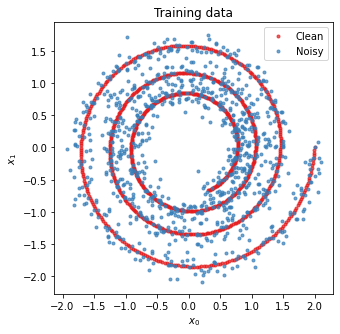

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(x_train[:, 0], x_train[:, 1], '.', label="Clean", color=pal[0], **plot_kws)
ax.plot(x_train_noisy[:, 0], x_train_noisy[:, 1], '.', label="Noisy", color=pal[1], **plot_kws)

ax.set(title='Training data', xlabel='$x_0$', ylabel='$x_1$')
ax.legend()
fig.show()

In [13]:
# Allow Trend Filtered method to work with linear functions
diffs[5] = ('Trend Filtered', ps.SINDyDerivative(kind='trend_filtered', order=1, alpha=1e-2))

equations_clean = {}
equations_noisy = {}
coefficients_clean = {}
coefficients_noisy = {}
input_features = ['x', 'y']
threshold = 0.5

for name, method in diffs:
    model = ps.SINDy(
        differentiation_method=method,
        optimizer=ps.STLSQ(threshold=threshold),
        t_default=dt,
        feature_names=input_features
    )
    
    model.fit(x_train)
    equations_clean[name] = model.equations()
    coefficients_clean[name] = model.coefficients()
    
    model.fit(x_train_noisy)
    equations_noisy[name] = model.equations()
    coefficients_noisy[name] = model.coefficients()

In [14]:
print_equations(equations_clean, equations_noisy)

                               Noiseless                                Noisy                                   
PySINDy Finite Difference                                                                                       
                               x0=2.006 y                               x0=2.022 y                              
                               x1=-1.994 x                              x1=-2.016 x                             
-------------------------------------------------------------------------------------------
Finite Difference                                                                                               
                               x0=2.006 y                               x0=2.034 y                              
                               x1=-1.994 x                              x1=-2.042 x                             
-------------------------------------------------------------------------------------------
Smoothed Finite Differenc

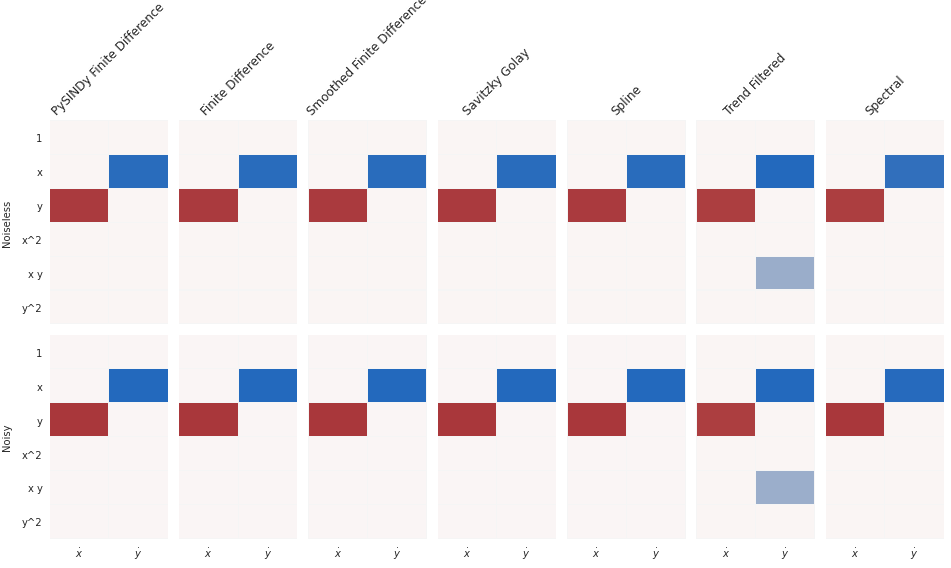

In [15]:
feature_names = model.get_feature_names()
compare_coefficient_plots(
    coefficients_clean,
    coefficients_noisy,
    input_features=input_features,
    feature_names=feature_names
)

### Lorenz system

$$ \begin{aligned} \dot x &= 10(y-x)\\ \dot y &= x(28 - z) - y \\ \dot z &= xy - \tfrac{8}{3} z, \end{aligned} $$


In [16]:
noise_level = 0.5

In [17]:
# Generate measurement data
dt = .002

t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span, x0_train, t_eval=t_train, **integrator_keywords).y.T
x_train_noisy = x_train + noise_level * np.random.randn(*x_train.shape)

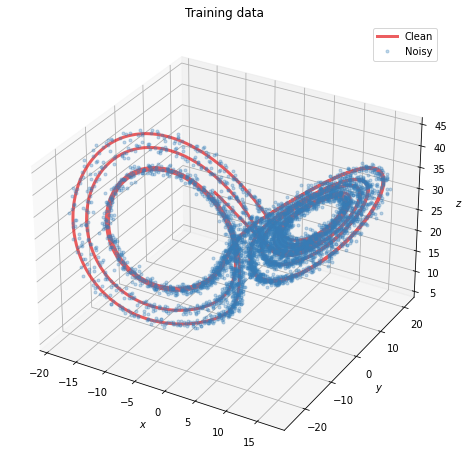

In [18]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.plot(
    x_train[:, 0],
    x_train[:, 1],
    x_train[:, 2],
    color=pal[0],
    label='Clean',
    **plot_kws
)

ax.plot(
    x_train_noisy[:, 0],
    x_train_noisy[:, 1],
    x_train_noisy[:, 2],
    '.',
    color=pal[1],
    label='Noisy',
    alpha=0.3,
)
ax.set(title='Training data', xlabel="$x$", ylabel="$y$", zlabel="$z$")
ax.legend()
fig.show()

In [19]:
equations_clean = {}
equations_noisy = {}
coefficients_clean = {}
coefficients_noisy = {}
input_features = ['x', 'y', 'z']

threshold = 0.5

for name, method in diffs:
    model = ps.SINDy(
        differentiation_method=method,
        optimizer=ps.STLSQ(threshold=threshold),
        t_default=dt,
        feature_names=input_features
    )
    
    model.fit(x_train)
    equations_clean[name] = model.equations()
    coefficients_clean[name] = model.coefficients()
    
    model.fit(x_train_noisy)
    equations_noisy[name] = model.equations()
    coefficients_noisy[name] = model.coefficients()

/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:176: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  "coefficients".format(self.threshold)
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:176: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  "coefficients".format(self.threshold)


In [20]:
print_equations(equations_clean, equations_noisy)

                               Noiseless                                Noisy                                   
PySINDy Finite Difference                                                                                       
                               x0=-9.999 x + 9.999 y                    x0=-9.939 x + 9.975 y                   
                               x1=27.992 x + -0.999 y + -1.000 x z      x1=24.924 x + -0.933 x z                
                               x2=-2.666 z + 1.000 x y                  x2=-2.622 z + 0.994 x y                 
-------------------------------------------------------------------------------------------
Finite Difference                                                                                               
                               x0=-9.999 x + 9.999 y                    x0=-9.873 x + 9.907 y                   
                               x1=27.993 x + -0.999 y + -1.000 x z      x1=0.633 1 + 24.937 x + -0.933 x z      
    

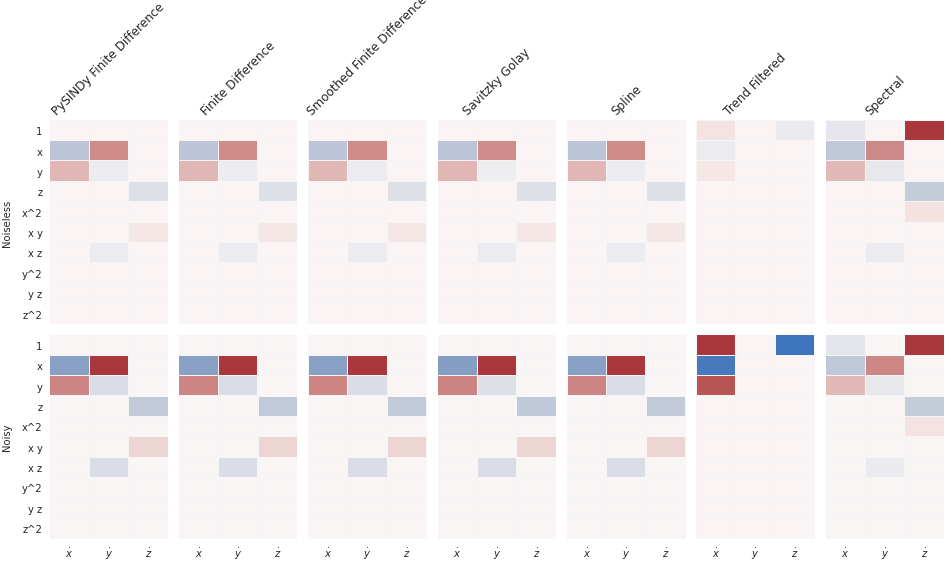

In [21]:
feature_names = model.get_feature_names()
compare_coefficient_plots(
    coefficients_clean,
    coefficients_noisy,
    input_features=input_features,
    feature_names=feature_names
)